In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import noisereduce as nr
from joblib import Parallel, delayed
import multiprocessing
from tqdm import tqdm

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import jiwer  
import time

import pywt 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense, Dropout, Masking
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

c:\Users\gabry\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Preparation

## Loading Data

In [2]:
# Konfigurasi
DATASET_PATH = "augdata"
COMMANDS = ["baca", "berhenti", "foto", "halo", "info", "kembali", "ulang"]

In [3]:
# Load data
X = []
y = []

for label in COMMANDS:
    folder_path = os.path.join(DATASET_PATH, label)
    for filename in os.listdir(folder_path):
        if filename.endswith(".wav"):
            file_path = os.path.join(folder_path, filename)
            X.append(file_path)
            y.append(label)

X = np.array(X)  
y = np.array(y)

In [4]:
len(X)

17787

In [5]:
# Buat dataframe
df = pd.DataFrame()
df['speech'] = X 
df['label'] = y

df.head()

,speech,label
0,augdata\baca\baca100_dyn.wav,baca
1,augdata\baca\baca100_noise.wav,baca
2,augdata\baca\baca100_original.wav,baca
3,augdata\baca\baca100_pitch.wav,baca
4,augdata\baca\baca100_shift.wav,baca


In [6]:

df['label'].value_counts()

label
kembali     2576
foto        2548
baca        2541
berhenti    2541
ulang       2541
info        2527
halo        2513
Name: count, dtype: int64

In [7]:
# Tahapan Preprocessing

def load_audio(file_path, sr=16000):
    audio, sample_rate = librosa.load(file_path, sr=sr)
    return audio / np.max(np.abs(audio)), sample_rate 

In [8]:
# Dapatkan jumlah core
num_cores = multiprocessing.cpu_count()

# Copy DataFrame
dfn = df.copy()

# Jalankan preprocessing
results = Parallel(n_jobs=num_cores)(
    delayed(load_audio)(file_path)
    for file_path in dfn['speech']
)

dfn.head()


,speech,label
0,augdata\baca\baca100_dyn.wav,baca
1,augdata\baca\baca100_noise.wav,baca
2,augdata\baca\baca100_original.wav,baca
3,augdata\baca\baca100_pitch.wav,baca
4,augdata\baca\baca100_shift.wav,baca


## MFCC

In [9]:
def extract_mfcc(audio, sample_rate, n_mfcc=13):
    """Extract MFCC features from audio"""
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    return mfcc.T  # shape: (time_steps, n_mfcc)

def full_mfcc_pipeline(file_path):
    """Full processing pipeline for a single audio file"""
    audio, sr = load_audio(file_path)
    return extract_mfcc(audio, sr)

def parallel_mfcc_extraction(file_paths, n_jobs=-1):
    return Parallel(n_jobs=n_jobs)(
        delayed(full_mfcc_pipeline)(file_path)
        for file_path in tqdm(file_paths, desc="Extracting MFCC features")
    )

# Usage
dfn['mfcc'] = parallel_mfcc_extraction(dfn['speech'].values)
dfn.head()


# # Fungsi WPD + MFCC Extraction (Optimized)
# def extract_wpd_mfcc(audio, sr, wavelet='db4', maxlevel=2, n_mfcc=8, n_fft=512, hop_length=256):
#     wp = pywt.WaveletPacket(data=audio, wavelet=wavelet, mode='symmetric', maxlevel=maxlevel)
    
#     # Ambil 4 node pertama saja untuk efisiensi
#     nodes = wp.get_level(maxlevel, order='freq')[:4]
    
#     mfcc_list = []
#     for node in nodes:
#         data = node.data
#         if len(data) < n_fft:
#             continue
#         mfcc = librosa.feature.mfcc(
#             y=data, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length
#         )
#         mfcc_list.append(mfcc.T)
    
#     return mfcc_list

# # Fungsi Padding dan Gabungkan (Optimized)
# def pad_and_concatenate(mfcc_list, max_len=128):
#     padded = []
#     for mfcc in mfcc_list:
#         if mfcc.shape[0] > max_len:
#             mfcc = mfcc[:max_len, :]
#         else:
#             pad_width = max_len - mfcc.shape[0]
#             mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
#         padded.append(mfcc)
    
#     # Kalau tidak ada MFCC valid, return dummy zero array
#     if not padded:
#         return np.zeros((max_len, 8 * 4))  # 4 nodes x 8 MFCC
    
#     return np.concatenate(padded, axis=1)  # shape: [max_len, 32]

# # Parallel MFCC Extraction (Optimized)
# def parallel_mfcc_extraction(audio_paths, sr=16000, max_len=128, wavelet='db4', maxlevel=2):
#     def process_audio(audio_path):
#         audio, _ = librosa.load(audio_path, sr=sr)
#         mfcc_segments = extract_wpd_mfcc(audio, sr, wavelet, maxlevel)
#         return pad_and_concatenate(mfcc_segments, max_len)
    
#     return Parallel(n_jobs=-1)(delayed(process_audio)(path) for path in audio_paths)

# dfn['mfcc'] = parallel_mfcc_extraction(dfn['speech'].values)
# dfn.head()

Extracting MFCC features: 100%|██████████| 17787/17787 [00:24<00:00, 719.64it/s]


,speech,label,mfcc
0,augdata\baca\baca100_dyn.wav,baca,"[[-478.13416, 94.535934, 24.319994, 2.3843186,..."
1,augdata\baca\baca100_noise.wav,baca,"[[-207.67798, -0.77459997, -3.0665402, 0.40385..."
2,augdata\baca\baca100_original.wav,baca,"[[-478.19656, 94.49435, 24.281418, 2.3394156, ..."
3,augdata\baca\baca100_pitch.wav,baca,"[[-426.4783, 99.649895, 4.1880846, 3.2213457, ..."
4,augdata\baca\baca100_shift.wav,baca,"[[-476.39615, 97.6118, 23.239983, 7.5516615, 1..."


In [10]:
# Konversi MFCC menjadi array 3D: (samples, timesteps, n_mfcc)
X_mfcc = pad_sequences(dfn['mfcc'], padding='post', dtype='float32')  


le = LabelEncoder()
y_encoded = le.fit_transform(dfn['label'])

# Print the encoding assignment
for label, encoded in zip(le.classes_, range(len(le.classes_))):
    print(f"'{label}' -> {encoded}")


'baca' -> 0
'berhenti' -> 1
'foto' -> 2
'halo' -> 3
'info' -> 4
'kembali' -> 5
'ulang' -> 6


# Modeling

In [11]:
# Split Data
X_train, X_val, y_train, y_val = train_test_split(
    X_mfcc, y_encoded, test_size=0.1, stratify=y_encoded, random_state=42
    )

In [12]:
# One-hot encoding 
num_classes = len(np.unique(y_encoded))
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)

In [14]:
# Modeling

model = Sequential([
    Masking(mask_value=0.0, input_shape=(X_mfcc.shape[1], X_mfcc.shape[2])),
    LSTM(128, return_sequences=True),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dropout(0.2),
    
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 146, 13)           0         
                                                                 
 lstm (LSTM)                 (None, 146, 128)          72704     
                                                                 
 lstm_1 (LSTM)               (None, 146, 64)           49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [15]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


In [16]:
# Training
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

# val_accuracy terbaik
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1  
print(f"Val accuracy terbaik: {best_val_acc:.4f} pada epoch ke-{best_epoch}")

Epoch 1/100
501/501 [==============================] - 33s 44ms/step - loss: 0.7214 - accuracy: 0.7451 - val_loss: 0.2982 - val_accuracy: 0.9112
Epoch 2/100
501/501 [==============================] - 20s 40ms/step - loss: 0.1653 - accuracy: 0.9552 - val_loss: 0.1490 - val_accuracy: 0.9545
Epoch 3/100
501/501 [==============================] - 21s 42ms/step - loss: 0.0799 - accuracy: 0.9789 - val_loss: 0.0834 - val_accuracy: 0.9781
Epoch 4/100
501/501 [==============================] - 21s 43ms/step - loss: 0.0588 - accuracy: 0.9853 - val_loss: 0.0622 - val_accuracy: 0.9837
Epoch 5/100
501/501 [==============================] - 21s 43ms/step - loss: 0.0535 - accuracy: 0.9859 - val_loss: 0.0271 - val_accuracy: 0.9933
Epoch 6/100
501/501 [==============================] - 21s 42ms/step - loss: 0.0436 - accuracy: 0.9888 - val_loss: 0.0128 - val_accuracy: 0.9949
Epoch 7/100
501/501 [==============================] - 21s 42ms/step - loss: 0.0362 - accuracy: 0.9920 - val_loss: 0.0214 - val_ac

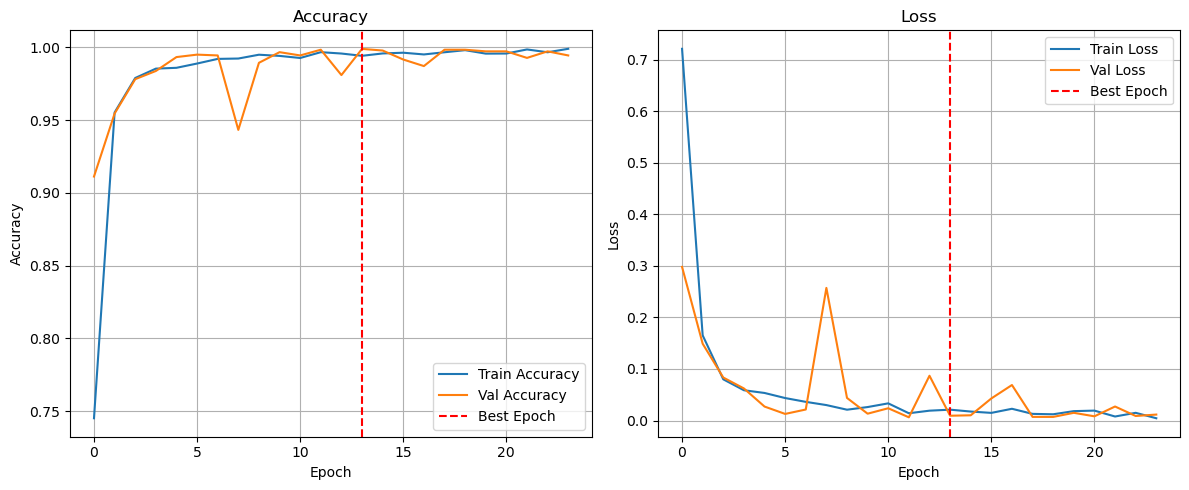

In [17]:
# Grafik akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.axvline(best_epoch-1, color='r', linestyle='--', label='Best Epoch')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Grafik loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.axvline(best_epoch-1, color='r', linestyle='--', label='Best Epoch')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Evaluasi

# Predict
start = time.time()
y_pred_probs = model.predict(X_val)
end = time.time()

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val_cat, axis=1)

# WER
ref = [le.classes_[i] for i in y_true]
hyp = [le.classes_[i] for i in y_pred]
wer = jiwer.wer(ref, hyp)

# RTF
audio_duration_total = (X_val.shape[0] * X_val.shape[1]) / 16000  # asumsi 16kHz
rtf = (end - start) / audio_duration_total

# Precision, Recall, F1 Score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Classification report
report = classification_report(y_true, y_pred, target_names=le.classes_)
print("=== Classification Report ===")
print(report)
print(f"Word Error Rate (WER): {wer:.4f}")
print(f"Real Time Factor (RTF): {rtf:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

56/56 [==============================] - 4s 20ms/step
=== Classification Report ===
              precision    recall  f1-score   support

        baca       1.00      1.00      1.00       254
    berhenti       1.00      1.00      1.00       254
        foto       1.00      1.00      1.00       255
        halo       0.99      1.00      1.00       251
        info       1.00      1.00      1.00       253
     kembali       1.00      1.00      1.00       258
       ulang       1.00      1.00      1.00       254

    accuracy                           1.00      1779
   macro avg       1.00      1.00      1.00      1779
weighted avg       1.00      1.00      1.00      1779

Word Error Rate (WER): 0.0011
Real Time Factor (RTF): 0.2437
Precision (weighted): 0.9989
Recall (weighted): 0.9989
F1 Score (weighted): 0.9989
